# Python spatial notebooks 1 : utilisation de rasterio sur de l'imagerie satellite

Cyril Bernard, fév 2022

## Objectifs

Nous continuons d'explorer les possibilités du package **rasterio**, avec cette fois-ci une image Sentinel-2 téléchargée sur la plateforme Copernicus.

**Connaissances prérequises** : avoir lu le précédent notebook


## Données utilisées

- Occupation du sol 2015 des Pyrénées-Orientales (fichiers .shp)
- Image Sentinel-2 du 2021-08-20 des Pyrénées-Orientales (fichiers .jp2) 


## Sommaire

**[Partie 4 - application sur une image Sentinel 2 (notebook suivant)](#partie-4)**

- lecture des bandes d'une image Sentinel-2 (Openhub Copernicus)
- comment extraire une fenêtre sans charger l'ensemble des données ?
- comment générer 1 raster multibandes à partir de 4 rasters monobandes ?
- comment calculer les quantiles avec les valeurs de chaque bande ?
- comment ajuster les valeurs pour visualiser l'image en RGB ?
- comment calculer un indice à partir des bandes d'1 raster ? Exemple : le NDVI
- comment lire les données et calculer un indice bloc par bloc ?


## 4ème partie - application sur une image Sentinel 2<a class="anchor" id="partie-4"></a>

### Liens utiles

Voici quelques liens utiles à propos des données Sentinel2 sur Copernicus :
- liste des bandes : <https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-2/instrument-payload/resolution-and-swath>
- nomenclature des fichiers : https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/naming-convention
- format de données Sentinel-SAFE : <https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/data-formats> (voir aussi <https://gdal.org/drivers/raster/sentinel2.html>)


### Téléchargement des données

Nous allons télécharger dans le répertoire `data/Copernicus` l'image Sentinel à partir du site <https://scihub.copernicus.eu/>.

Le package `sentinelsat` permet de rechercher et télécharger des données Sentinel2. Lorsqu'on connaît l'identifiant de l'image sous la forme UUID (ici : `8199a929-9c6c-4489-88f0-34847fcfb9cf`) on peut l'utiliser pour télécharger l'image. Attention toutefois si l'image est archivée à long terme il peut y avoir un temps d'attente pour que les fichiers soient disponibles en téléchargement.

Pour réaliser cette opération vous devez disposer d'un compte sur la plateforme Copernicus (<https://scihub.copernicus.eu/>) et renseigner ci-dessous votre identifiant.  


In [4]:
from os import mkdir
from os.path import join
from sentinelsat import SentinelAPI

# creation du repertoire data/Copernicus
path_img = join('data', 'Copernicus')
try:
    mkdir(path_img)
    print("Répertoire Copernicus créé")
except FileExistsError:
    # existe déjà
    print("Répertoire Copernicus existant")

my_userid = 'user'
my_password = 'password'
api = SentinelAPI(my_userid, my_password, 'https://apihub.copernicus.eu/apihub')

# S2A_MSIL2A_20210820T104021_N0301_R008_T31TDH_20210820T153044.zip
# téléchargement du fichier avec son UUID

product_id = '8199a929-9c6c-4489-88f0-34847fcfb9cf'
#api.download(product_id, directory_path=path_img)


Répertoire Copernicus existant


MD5 checksumming:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

{'id': '8199a929-9c6c-4489-88f0-34847fcfb9cf',
 'title': 'S2A_MSIL2A_20210820T104021_N0301_R008_T31TDH_20210820T153044',
 'size': 1191441292,
 'md5': 'b6149c41ed276192d9eedbc589531235',
 'date': datetime.datetime(2021, 8, 20, 10, 40, 21, 24000),
 'footprint': 'POLYGON((1.7656944498199 43.346194685301704,3.120433646053401 43.352791985217806,3.118527220871465 42.364010656318975,1.785227256908992 42.35763630855867,1.7656944498199 43.346194685301704))',
 'url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('8199a929-9c6c-4489-88f0-34847fcfb9cf')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2021, 8, 20, 18, 21, 12, 343000),
 'Ingestion Date': datetime.datetime(2021, 8, 20, 18, 20, 35, 986000),
 'quicklook_url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('8199a929-9c6c-4489-88f0-34847fcfb9cf')/Products('Quicklook')/$value",
 'path': 'data\\Copernicus\\S2A_MSIL2A_20210820T104021_N0301_R008_T31TDH_20210820T153044.zip',
 'downloaded_bytes': 1191441292}

### Lecture des fichiers

Ouvrons maintenant une image Sentinel2 téléchargée sur la plateforme Copernicus. Il s'agit d'une image du 20/08/2021 sur les Pyrénées-Orientales traitées au niveau 2A. 

Nous utiliserons les bandes 2, 3, 4 et 8 (B, V, R, PIR) avec une résolution de 10 m. Chaque bande est dans un fichier '.jp2' séparé : nous ouvrons les 4 fichiers, un par un.


In [5]:
from os.path import join, exists

import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# repertoire donnees
d_data = "data"

# repertoire copernicus
d_img_s2 = join(
    d_data, "Copernicus", "S2A_MSIL2A_20210820T104021_N0301_R008_T31TDH_20210820T153044.SAFE",
    "GRANULE", "L2A_T31TDH_A032180_20210820T104404", "IMG_DATA", "R10m"
)

# repertoire sortie
d_output = "output"

tile_s2 = "T31TDH_20210820T104021"
f_s2_b02 = join(d_img_s2, tile_s2 + "_B02_10m.jp2")
f_s2_b03 = join(d_img_s2, tile_s2 + "_B03_10m.jp2")
f_s2_b04 = join(d_img_s2, tile_s2 + "_B04_10m.jp2")
f_s2_b08 = join(d_img_s2, tile_s2 + "_B08_10m.jp2")

ds_s2_b02 = rasterio.open(f_s2_b02) # B2 = blue
ds_s2_b03 = rasterio.open(f_s2_b03) # B3 = green
ds_s2_b04 = rasterio.open(f_s2_b04) # B4 = red
ds_s2_b08 = rasterio.open(f_s2_b08) # B8 = nir

# caracteristique du dernier raster avec profile
src_kwds = ds_s2_b08.profile
src_kwds

{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32631), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 4800000.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True}

Nous remarquons que le driver utilisé pour ouvrir le fichier est **JP2OpenJPEG**. Les valeurs sont codées en entier non-signé sur 16 bits. Le CRS utilisé est _UTM 31 N WGS84_ (EPSG:32631.)

### Comment extraire une fenêtre ? Comment générer 1 raster multibandes à partir de 3 rasters monobande ?

Exercice : définir une fenêtre de 10x10 km autour du point X, Y UTM 31N = (452700, 4718570) (commune de Prades). Extraire les données de cette fenêtre sur les 4 bandes : (B, G, R, NIR), et générer un nouveau raster à 4 bandes.

Il nous faut d'abord identifier les coordonnées pixel (ligne et colonne) du point en haut à gauche pour définir la fenêtre de 1000 x 1000 pixels.

In [6]:
from rasterio.windows import Window
# nous utilisons la bande B02
x_geo, y_geo = (447700, 4723570)
x_pix, y_pix = ds_s2_b02.index(x_geo, y_geo)
win = Window(y_pix, x_pix, 1000, 1000)
win

Window(col_off=4774, row_off=7643, width=1000, height=1000)

Ensuite, nous créons un nouveau raster et, bande par bande, nous procédons à l'extraction des données / écriture des données.

L'utilisation de la méthode `set_band_description` est recommandée pour écrire dans le fichier une description des bandes.

In [4]:
%%time
# calculer fonction transform pour la fenetre
win_transform = rasterio.windows.transform(win, ds_s2_b02.transform)
# profil fichier sortie : GeoTIFF LZW, 4 bandes, 1000x1000
dst_kwds = src_kwds.copy()
dst_kwds.update({
    'driver': "GTiff",
    'compress': "LZW",
    'count': 4,
    'transform': win_transform,
    'width': 1000, 
    'height': 1000
})

# ecrire, bande par bande 
list_ds = [ds_s2_b02, ds_s2_b03, ds_s2_b04, ds_s2_b08]
desc_bd = {
    1: "Reflectance B02", 2: "Reflectance B03", 
    3: "Reflectance B04", 4: "Reflectance B08"
}

f_output = join(d_output, 'Extract_S2_20210820.tif')
with rasterio.open(f_output, 'w', **dst_kwds) as dst_dataset:
    print("Création du raster")
    for (i, src_dataset) in enumerate(list_ds, 1):
        values = src_dataset.read(1, window=win) 
        print(i, desc_bd[i], values.shape, values.dtype)
        dst_dataset.write(values, i)
        dst_dataset.set_band_description(i, desc_bd[i]) 
dst_dataset.close()


Création du raster
1 Reflectance B02 (1000, 1000) uint16
2 Reflectance B03 (1000, 1000) uint16
3 Reflectance B04 (1000, 1000) uint16
4 Reflectance B08 (1000, 1000) uint16
CPU times: total: 3.25 s
Wall time: 3.31 s


### Comment calculer les percentiles dans les valeurs de chaque bande ?

Dans l'exemple suivant, avec la fonction `percentile` de **numpy**, on calcule un intervalle de valeurs qui exclut les 2 % de valeurs les plus faibles et les 2 % les plus fortes, pour chaque bandes. 

De cette manière on exclut les valeurs extrêmes. Cela est utile pour visualiser les données comme on le verra dans la suite.

In [5]:
f_output = join(d_output, 'Extract_S2_20210820.tif')
with rasterio.open(f_output, 'r', **dst_kwds) as s2_dataset:
    values_b02 = s2_dataset.read(1)
    values_b03 = s2_dataset.read(2)
    values_b04 = s2_dataset.read(3)
    values_b08 = s2_dataset.read(4)
s2_dataset.close()
    
# calculer percentile 2 - 98
perc_2_b02 = np.percentile(values_b02, (2, 98))
perc_2_b03 = np.percentile(values_b03, (2, 98))
perc_2_b04 = np.percentile(values_b04, (2, 98))
perc_2_b08 = np.percentile(values_b08, (2, 98))

print("b02 [q 0.02 q 0.98] : ", perc_2_b02)
print("b03 [q 0.02 q 0.98] : ", perc_2_b03)
print("b04 [q 0.02 q 0.98] : ", perc_2_b04)
print("b05 [q 0.02 q 0.98] : ", perc_2_b08)
   

b02 [q 0.02 q 0.98] :  [129. 861.]
b03 [q 0.02 q 0.98] :  [ 315. 1196.]
b04 [q 0.02 q 0.98] :  [ 171. 1534.]
b05 [q 0.02 q 0.98] :  [1720. 4209.]


**Remarque** : en chargeant toutes les bandes puis en utilisant la fonction `reshape` de numpy pour "aplatir" les 4 bandes sur 1D, on peut arriver au même résultat plus élégamment et plus rapidement.

In [6]:
f_output = join(d_output, 'Extract_S2_20210820.tif')
with rasterio.open(f_output, 'r', **dst_kwds) as s2_dataset:
    s2_transform = s2_dataset.transform
    values = s2_dataset.read()
s2_dataset.close()

# utilisation de reshape pour passer de : (bandes, lignes, colonnes) à : (bandes, valeurs)
values_2d = values.reshape(4, -1)
print(values.shape, " > " , values_2d.shape)

# 
min_bands = np.min(values_2d, axis=1)
p2_bands = np.percentile(values_2d, 2, axis=1)
p98_bands = np.percentile(values_2d, 98, axis=1)
max_bands = np.max(values_2d, axis=1)

print(min_bands)
print(p2_bands)
print(p98_bands)
print(max_bands)


(4, 1000, 1000)  >  (4, 1000000)
[ 1  1  1 81]
[ 129.  315.  171. 1720.]
[ 861. 1196. 1534. 4209.]
[19136 17952 17088 16017]


### Comment visualiser l'image en RGB ?

L'image générée précédemment rassemble les 4 bandes : respectivement B, G, R, NIR sur une zone de 100 km². Comment faire pour visualiser la scène en couleurs naturelles, c'est à dire avec les 3 premières bandes ? 

Après avoir charger toutes les bandes, avec la méthode d'indexation propre à numpy, nous pouvons extraire les bandes B04, B03, B02.

Rappel : lorsqu'on charge toutes les bandes avec `read()`, les axes sont dans cet ordre pour le tableau 3D obtenu :

* axe 0 : bandes
* axe 1 : lignes du raster
* axe 2 : colonnes du raster


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 1000, 1000)
(3, 1000, 1000)


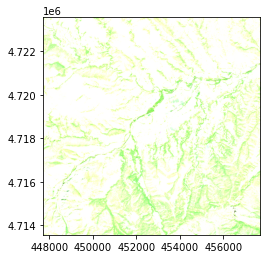

<AxesSubplot:>

In [7]:
from rasterio.plot import show
# nous reprenons la tableau 3D avec les 4 bandes.
print(values.shape)
# values couleurs naturelles : r=b04, g=b03, b=b02 
values_natcol = values[(2,1,0), :, :]
print(values_natcol.shape)
show(values_natcol, transform=s2_transform)


#### Ajustement linéaire

Pour les besoins de l'affichage avec matplotlib, les valeurs doivent être ajustée entre 0 et 1.
Si on se base sur les valeurs minimales et maximales de chaque bande et qu'on ajuste les valeurs entre ces 2 bornes, il est possible que ds valeurs extrêmes déséquilibre l'affichage (les détails intéressants n'apparaîtront pas).

En ajustant linéairement les valeurs de chaque bande autour des percentiles 2 et 98, on ignore les 2% de valeurs  min et max. 


In [8]:
# on calcule pour chaque bande les valeurs a et b
# pour appliquer l'équation y = ax + b
a = 1 / (p98_bands - p2_bands)
print(a)
b = p2_bands / (p98_bands - p2_bands)
print(b)

[0.00136612 0.00113507 0.00073368 0.00040177]
[0.17622951 0.35754824 0.12545855 0.69104058]


In [9]:
# pour appliquer l'équation y = ax + b sur chaque bande,
# il faut que a et b aient 3 dimensions
a_3d = a.reshape((4,1,1))
b_3d = b.reshape((4,1,1))
# ajuster entre 0 et 1
values_adjust = (a_3d * values) - b_3d
values_adjust = np.where(values_adjust > 0., values_adjust, 0.)
values_adjust = np.where(values_adjust < 1., values_adjust, 1.)


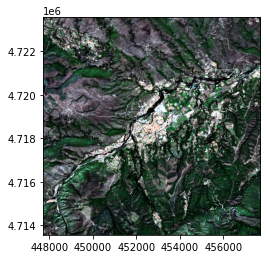

<AxesSubplot:>

In [10]:
# couleurs naturelles apres ajustement
values_natcol = values_adjust[(2,1,0), :, :]
show(values_natcol, transform=s2_transform)


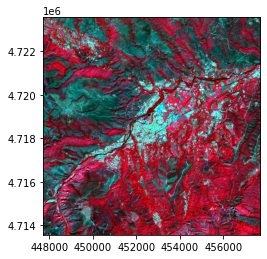

<AxesSubplot:>

In [11]:
# autre exemple : composition infrarouge
values_natcol = values_adjust[(3,2,1), :, :]
show(values_natcol, transform=s2_transform)


### Comment visualiser la distribution des valeurs ?

Le module **rasterio.plot** propose une fonction `show_hist`, cependant si on souhaite vraiment contrôler l'aspect du graphique (exemple : la paramètre range pour les bornes des valeurs représentées), il est préférable d'utiliser directement la fonction `hist` de matplotlib.

In [20]:
# charger les valeurs des bandes

f_output = join(d_output, 'Extract_S2_20210820.tif')
with rasterio.open(f_output, 'r', **dst_kwds) as ex_dataset:
    values =  ex_dataset.read()
    
# utilisation de reshape pour passer de : (bandes, lignes, colonnes) à : (valeurs, bandes)
values_2d = values.reshape(4, -1).T
print(values.shape, " > " , values_2d.shape)


(4, 1000, 1000)  >  (1000000, 4)


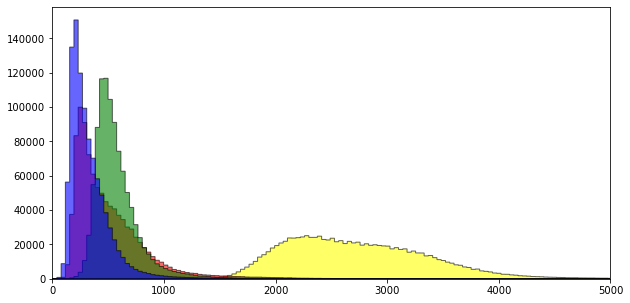

In [21]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlim(0, 5000)
ax.hist(values_2d, bins=500, alpha=0.6,
         histtype='stepfilled', color=('blue', 'green', 'red', 'yellow'),
         edgecolor='black');


(1000000,)

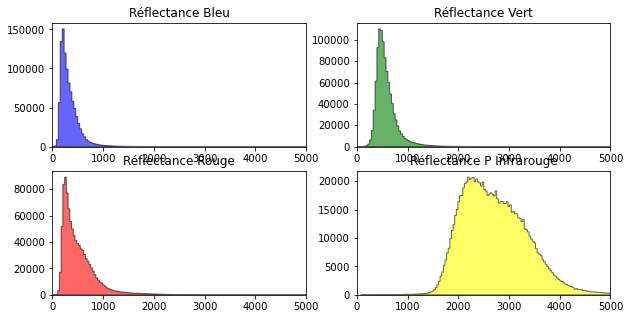

In [44]:
fig, ax = plt.subplots(2,2, figsize=(10,5))
#ax.set_xlim(0, 5000)
kwds = {
    'alpha': 0.6,
    'bins': 500,
    'histtype': 'stepfilled',
    'edgecolor': 'black'
}
ax[0,0].set_xlim(0, 5000)
ax[0,0].set_title("Réflectance Bleu")
h1 = ax[0,0].hist(values_b02.flatten(), color='blue', **kwds)
ax[0,1].set_xlim(0, 5000)
ax[0,1].set_title("Réflectance Vert")
h1 = ax[0,1].hist(values_b03.flatten(), color='green', **kwds)
ax[1,0].set_xlim(0, 5000)
ax[1,0].set_title("Réflectance Rouge")
h1 = ax[1,0].hist(values_b04.flatten(), color='red', **kwds)
ax[1,1].set_xlim(0, 5000)
ax[1,1].set_title("Réflectance P Infrarouge")
h1 = ax[1,1].hist(values_b08.flatten(), color='yellow', **kwds)


### Comment utiliser numpy comme calculatrice raster. Exemple 2 : calcul d'indice.

Nous souhaitons calculer l'indice de végétation par différence normalisé (**NDVI**) sur l'image Sentinel2 en résolution 10m. 

La formule pour calculer l'indice est NDVI = (PIR - R) / (PIR + R). Dans notre cas, NDVI = (B08 - B04) / (B08 + B04).

**2 façons de procéder se présentent à nous**.

1) un méthode simple mais **gourmande en RAM** : charger les bandes 4 et 8 en mémoire, calculer et enregistrer le NDVI.

2) un méthode moins directe mais **plus optimale** : calculer et enregistrer le NDVI **bloc par bloc**

Commençons par la méthode la plus simple : charger toutes les données en mémoire.

In [66]:
%%time
# lire les bandes R et PIR (B04 et B08)
values_b04 = ds_s2_b04.read(1)
values_b08 = ds_s2_b08.read(1)
print(values_b04.dtype, values_b08.dtype)

uint16 uint16
CPU times: total: 37.6 s
Wall time: 3.22 s


**Attention** au cas (rare) où b08 + b04 = 0. 

Dans ce cas, pour éviter une division par 0, on masque les pixels. Le NDVI est d'abord calculé comme `float` puis converti en entier sur une échelle de 0 à 1000, avec -9999 pour les pixels masqués.

**Attention également au type des données** du raster. Par exemple, dans notre cas, avec la soustractraction sur des entiers non signés, on peut se retrouver avec 2 - 3 = 65535 ! 

La solution la plus "facile" pour contourner ce problème est de convertir les données de données en entiers signés ou en flottant à la lecture du raster.


In [67]:
# attention aux soustraction sur des entiers non signés ! par exemple
a = np.uint16([2,1,3])
b = np.uint16([3,1,2])
# incorrect
print(a - b)
# correct
print(a.astype(np.int16) - b.astype(np.int16))
# correct
print(a.astype(np.float32) - b.astype(np.float32))

[65535     0     1]
[-1  0  1]
[-1.  0.  1.]


In [68]:
%%time
# les données sont lues en tant que flottants pour effectuer le calcul correctement
values_b04_f32 = values_b04.astype(np.float32)
values_b08_f32 = values_b08.astype(np.float32)
# si b08 + b04 > 0
# alors ndvi = (b08 - b04) / (b08 + b04) 
# sinon ndvi = -99 (valeur par défaut)
somme_pir_r = values_b08_f32 + values_b04_f32
# le résultat de la division sera de type float32
values_ndvi = np.divide(
    values_b08_f32 - values_b04_f32, 
    somme_pir_r,
    out = np.full(somme_pir_r.shape, -99., dtype=rasterio.float32),
    where = somme_pir_r > 0  
)


CPU times: total: 656 ms
Wall time: 616 ms


In [69]:
%%time
# enregistrement du fichier 
dst_kwds = src_kwds.copy()
dst_kwds.update({
    'driver': "GTiff",
    'nodata': -99.,
    'dtype': "float32"
})
f_output = join(d_output, 'ndvi_float32.tif')
with rasterio.open(f_output, 'w', **dst_kwds) as dst_dataset:
    dst_dataset.write(values_ndvi, 1)
dst_dataset.close()

CPU times: total: 438 ms
Wall time: 1.29 s


In [70]:
#%%time
# calcul ndvi : float64
#import numpy.ma as ma
#values_b04 = ds_s2_b04.read(1, out_dtype=rasterio.int16)
#values_b08 = ds_s2_b08.read(1, out_dtype=rasterio.int16)
#diff = values_b08 - values_b04
#somme = ma.masked_equal(values_b08 + values_b04, 0)
#values_ndvi = diff / somme
#ma.count_masked(values_ndvi)

#### Optimisations possibles

Dans l'exemple précédent, le NDVI calculé est compris entre -1. et 1 ; il est ensuite enregistré dans un raster de type flottant 32 bits de 495 Mo. Pour réduire la taille du fichier, on aurait pu enregistrer l'indice dans un raster de type entier 16 bits, après l'avoir multiplié par 1000 pour garder une précision suffisante. On peut aussi utiliser un paramètre de compression lors de l'enregistrement en GeoTIFF (exemple : LZW, Deflate, Packbits...)

Mais surtout, au lieu de charger entièrement les bandes 4 et 8 en mémoire (ce qui réprésente 240 Mo pour chaque bande), on pourrait procéder bloc par bloc. En effet, le profil des rasters JPEG-2000 en entrée nous montre qu'ils sont structurés en blocs de 1024x1024 pixels. C'est ce que nous allons voir dans le paragraphe suivant.


In [71]:
%%time
# calculer et enregistrer NDVI
def calc_ndvi(values_red, values_nir, div0_value=-99):
    """Compute NDVI. 
    Expected values are between (-1 * mltpl) and (1000 * mltpl)
    If (values_nir - values_red) == 0 then return value = (-9.999 * mltpl)
    
    Keyword arguments:
    values_red -- numpy array
    values_nir -- numpy array
    mltpl -- multiplier for output values
    out_dtype -- numpy output dtype, int16 or float32
    """
    # cast input values float32 : pour éviter les problèmes de signe ou de dépassement
    values_red_f32 = np.asarray(values_red, dtype=np.float32)
    values_nir_f32 = np.asarray(values_nir, dtype=np.float32)
    sum_nir_red = values_nir_f32 + values_red_f32
    # le résultat de la division sera de type float32
    values_ndvi = np.divide(
        values_nir_f32 - values_red_f32, 
        sum_nir_red,
        out = np.full(sum_nir_red.shape, div0_value),
        where = sum_nir_red > 0  
    )
    return (values_ndvi)

values_ndvi = calc_ndvi(values_b04, values_b08, div0_value=-9.999)
values_ndvi_int = np.asarray(values_ndvi * 1000, dtype=np.int16)
#print(values_ndvi_int.dtype, values_ndvi_int.min(), values_ndvi_int.max())

CPU times: total: 1.2 s
Wall time: 1.21 s


In [72]:
%%time
# enregistrement du fichier avec la compression LZW
dst_kwds = src_kwds.copy()
dst_kwds.update({
    'driver': "GTiff",
    'nodata': -9999,
    'dtype': "int16",
    'COMPRESS': "LZW"
})
f_output = join(d_output, 'ndvi_int16_lzw.tif')
with rasterio.open(f_output, 'w', **dst_kwds) as dst_dataset:
    dst_dataset.write(values_ndvi_int, 1)
dst_dataset.close()

CPU times: total: 2.84 s
Wall time: 2.92 s


In [73]:
%%time
# enregistrement du fichier avec la compression DEFLATE (Predictor=2, Zlevel=9)
dst_kwds = src_kwds.copy()
dst_kwds.update({
    'driver': "GTiff",
    'nodata': -9999,
    'dtype': "int16",
    'COMPRESS': "DEFLATE",
    'PREDICTOR': 2,
    'ZLEVEL': 9
})
f_output = join(d_output, 'ndvi_int16_deflate.tif')
with rasterio.open(f_output, 'w', **dst_kwds) as dst_dataset:
    dst_dataset.write(values_ndvi_int, 1)
dst_dataset.close()

CPU times: total: 11.5 s
Wall time: 11.6 s


### Comment utiliser numpy comme calculatrice raster. Exemple 3 : calcul bloc par bloc.

Nous avons précédemment calculé le NDVI en chargeant entièrement les bandes 4 et 8 en mémoire : cela représente 2 x 10980 x 1098 octets, soit plus de 240 Mo par bande. A quoi il faut ajouter les données intermédiaires générées par le calcul.

Une autre méthode est possible avec rasterio : la lecture, le calcul et l'écriture bloc par bloc. 
Cela présente 2 avantages : 

- la calcul occupera moins de RAM. D'après le profil des rasters en entrée, les données de chaque bande sont organisées en blocs de 1024x1024 pixels, soit 2 Mo par bloc.
- cela nous ouvre la porte du calcul parallélisé


In [74]:
# taille des bloc des bandes b04 et b08
print(ds_s2_b04.block_shapes)
print(ds_s2_b08.block_shapes)

[(1024, 1024)]
[(1024, 1024)]


Nous avons vu précédemment les fenêtres ou `windows` dans rasterio qui permettent de charger en mémoire une partie des données du raster. Les `block` sont des fenêtres prédéfinies dans un fichier raster, ce qui fait que leur lecture est très rapide.  

La fonction `block_windows` est un itérateur qui génère des fenêtres correspondant aux blocs. Elle prend comme paramètre l'index de la bande et produit un tuple avec :

- l'indice (ix, iy) du bloc, à partir de (0,0)
- une fenêtre


In [75]:
%%time
# lire valeurs et calculer le ndvi, bloc par bloc
nbloc = 0
for ji, win in ds_s2_b04.block_windows(1):
    values_red = ds_s2_b04.read(1, window=win)
    values_nir = ds_s2_b08.read(1, window=win)
    values_ndvi = calc_ndvi(values_red, values_nir, div0_value=-9.999)
    nbloc += 1
print("Nb de blocs traités :", nbloc)

Nb de blocs traités : 121
CPU times: total: 1.12 s
Wall time: 1.13 s


In [76]:
%%time
# calcul ndvi et enregistrement du fichier avec la compression LZW, bloc par bloc
dst_kwds = src_kwds.copy()
dst_kwds.update({
    'driver': "GTiff",
    'nodata': -9999,
    'dtype': "int16",
    'COMPRESS': "LZW"
})
f_output = join(d_output, 'ndvi_int16_lzw_blocks.tif')

with rasterio.open(f_output, 'w', **dst_kwds) as dst_dataset:
    nbloc = 0
    for ji, win in ds_s2_b04.block_windows(1):
        values_red = ds_s2_b04.read(1, window=win)
        values_nir = ds_s2_b08.read(1, window=win)
        values_ndvi = calc_ndvi(values_red, values_nir, div0_value=-9.999)
        values_ndvi_int = np.asarray(values_ndvi * 1000, dtype=np.int16)
        dst_dataset.write(values_ndvi_int, window=win, indexes=1)
    print("Nb de blocs traités :", nbloc)
dst_dataset.close()

Nb de blocs traités : 0
CPU times: total: 4.27 s
Wall time: 4.38 s


In [77]:
(values_ndvi[0:1,0:1] * 1000)

array([[801.8501997]])

In [78]:
(values_ndvi[0:1,0:1] * 1000).astype(np.int16)

array([[801]], dtype=int16)

### Comment rastériser une couche vectorielle ?

TODO : rastériser l'occupation du sol en 2015 (niveau 3 de nomenclature), en se basant sur l'étendue (25 x 25 km) 
et la résolution (25 m) de la dalle MNT précédemment ouverte. 